In [114]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import datetime
import time
import re

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import spacy
spacy.load('en')
from spacy.lang.en.stop_words import STOP_WORDS
import nltk
#nltk.download('wordnet') Download wordnet if not 
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

import gensim
from gensim.models.ldamodel import LdaModel
from gensim import corpora
import pyLDAvis.gensim
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# The Data

You are given the dataset ‘github_comments.tsv’ that carries 4000 comments that were published on pull requests on Github by developer teams.

**Comment:** the comment made by a developer on the pull request.  
**Comment_date:** date at which the comment was published  
**Is_merged:** shows whether the pull request on which the comment was made has been accepted or rejected.  
**Merged_at:** date at which the pull request was merged (if accepted).   
**Request_changes:** each comment is labelled either 1 or 0: if it’s labelled as 1 if the comment is a request for change in the code. If not, it’s labelled as 0.  

In [26]:
df = pd.read_csv('github_comments.tsv', sep='\t', index_col=0)
df.head()

,comment,comment_date,is_merged,merged_at,request_changes
0,@chef/maintainers,2017-05-29 10:54:23,0.0,NaN,0
1,omnibus builds are already in pain so merging to fix those,2017-05-25 20:34:45,1.0,2017-05-25 20:34:27,0
2,"@chef/client-core reviewage (lets not think too hard about the breakpoint resource itself, i just picked it because its the shortest bit of provider code out there)",2017-05-25 17:21:56,1.0,2017-05-25 19:05:10,0
3,"This blows up 14.04 because allow-downgrades is not supported there, so you'll need to figure out the first versions of ubuntu and debian that can safely support this and conditionally add the flag",2017-05-25 19:15:14,0.0,NaN,1
4,I know @lamont-granquist and @thommay are going to be unhappy about this one. This is absolutely a short term fix until we get choco on the windows jenkins nodes like it was before our system failure.,2017-05-23 22:58:13,1.0,2017-05-24 04:40:42,0


# Text Cleaning
**Goal:** Determine the nature of the data and clean out characters and words that do not contribute to the semantics of the comment.

In [27]:
df.dtypes

comment            object 
comment_date       object 
is_merged          float64
merged_at          object 
request_changes    int64  
dtype: object

In [103]:
parser = spacy.lang.en.English()


def tokenize(comments):
    token_list = []
    tokens = parser(comments) #Parse the comments with Spacy
    for token in tokens:
        if token.like_url:
            continue #filter out urls
        elif token.orth_.startswith('@'):
            continue #filter out mentions because they provide no semantic value to topic modelling.
        elif token.orth_.isspace():
            continue
        elif re.match('^[0-9].+[0-9]$', str(token)):
            continue
        else:
            token_list.append(token.lower_)
    return token_list


def get_lemma(token): #I'm using the WordNet dictionary from NLTK to lemmatize words.
    lemma = wn.morphy(token)
    if lemma is None:
        return token
    else:
        return lemma


def process_text(comments): #Combine both functions and remove stopwords
    tokens = tokenize(comments)
    tokens = [token for token in tokens if token not in STOP_WORDS]
    tokens = [token for token in tokens if len(token)>3] #Helps to remove symbols and contractions that made it through
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [104]:
start = time.time()
df['tokenized'] = df.comment.apply(lambda x: process_text(x))
print(f'Tokenizing text took {time.time()-start} seconds')

Tokenizing text took 69.4261200428009 seconds


In [105]:
df.head()

,comment,comment_date,is_merged,merged_at,request_changes,tokenized,tokenized_length
0,@chef/maintainers,2017-05-29 10:54:23,0.0,NaN,0,[maintainer],1
1,omnibus builds are already in pain so merging to fix those,2017-05-25 20:34:45,1.0,2017-05-25 20:34:27,0,"[omnibus, build, pain, merging]",5
2,"@chef/client-core reviewage (lets not think too hard about the breakpoint resource itself, i just picked it because its the shortest bit of provider code out there)",2017-05-25 17:21:56,1.0,2017-05-25 19:05:10,0,"[client, core, reviewage, let, think, hard, breakpoint, resource, pick, short, provider, code]",13
3,"This blows up 14.04 because allow-downgrades is not supported there, so you'll need to figure out the first versions of ubuntu and debian that can safely support this and conditionally add the flag",2017-05-25 19:15:14,0.0,NaN,1,"[blow, allow, downgrade, support, need, figure, version, ubuntu, debian, safely, support, conditionally, flag]",15
4,I know @lamont-granquist and @thommay are going to be unhappy about this one. This is absolutely a short term fix until we get choco on the windows jenkins nodes like it was before our system failure.,2017-05-23 22:58:13,1.0,2017-05-24 04:40:42,0,"[know, granquist, going, unhappy, absolutely, short, term, choco, windows, jenkins, node, like, system, failure]",15


In [106]:
df['tokenized_length'] = df.tokenized.apply(lambda x: len(x))
data = df[df.tokenized_length > 1] #Remove comments with 0-1 tokens. They provide little to no semantic value.

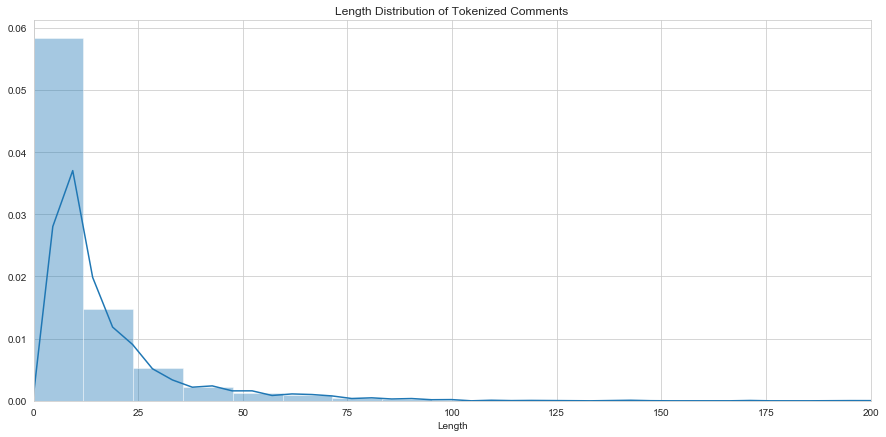

In [125]:
plt.figure(figsize=(15,7))
sns.distplot(df.tokenized.apply(lambda x: len(x)))
plt.xlabel('Length')
plt.xlim(0,200)
plt.title('Length Distribution of Tokenized Comments')
plt.show()

# Topic Identification  
**Goal:** Identify Topics by using the gensim implementation of Latent Dirchlet Allocation (LDA).
Cosine similarity of each row to the topics

In [121]:
#Create the Bag of Words to be used
dictionary = corpora.Dictionary(data.tokenized)
corpus = [dictionary.doc2bow(words) for words in data.tokenized]

ldamodel = LdaModel(corpus, num_topics=4, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.058*"thanks" + 0.040*"merge" + 0.019*"change" + 0.016*"commit" + 0.013*"look"')
(1, '0.013*"method" + 0.012*"think" + 0.011*"test" + 0.010*"case" + 0.009*"class"')
(2, '0.014*"need" + 0.011*"session" + 0.010*"change" + 0.007*"implementation" + 0.007*"user"')
(3, '0.051*"spring" + 0.021*"project" + 0.014*"hibernate" + 0.014*"jenkins" + 0.012*"test"')


In [122]:
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

The above visualization tells us 3 things.  
1. There are still symbols and contractions that need to be cleaned.  
2. Most of the top topics are very common words that do not provide much information as to problems that the comment is addressing.  
3. There are overlapping topics that we can combine.  
Topic 1 contains words like database, encoding, search, query which lead me to believe this topic is related to compiling data.  
Topic 2 consists of words that appear to be related to properties of objects.  
Topic 3 seems to deal mostly with github related keywords such as: "merge", "push", and "master",  as well as basic actions such as fixing, applying, and testing.
Topic 4 points to activities related to the spring project.  

It is challenging to get specific semantic meanings in each comment because the median length of each comment is relatively short. The topics also seem to have an words that may fit better in other topics. After doing some research, I found a blog that talked about using the coherence score as a metric to determine optimal number of clusters.

Ideas:  
Use Mallet implementation  
Gensim to find word similarities  
bigrams and trigrams  -this might take forever to run though

In [123]:
len(corpus)

3576